In [2]:
%load_ext rpy2.ipython
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
from scipy import stats
import sympy as sym
from IPython.display import Image

plt.rcParams['figure.figsize'] = (20, 7)


# Rare-event simulation
## Lecture 3
### Patrick Laub, Institut de Science Financière et d’Assurances

## Agenda

- Show you Markov chain Monte Carlo (MCMC)
- Go back to finish Markov chain example
- Explain MCMC

## MCMC: inputs

_Inputs_:
- $f_X(x)$, the _target density_ (known up to a normalising constant),
- $q(y \mid x)$, a _transition kernel_, gives the density of proposing a jump to $y$ given we're currently at $x$,
- $X_0$, our _starting position_, and $R$ the number of _replicates_ we want.

_Outputs_: $X_1, \dots, X_R \sim f_X(x)$, dependent but i.d.

_An example_:
- target is $f_X(x) \propto 2 + \sin(x)$ for $x \in [0, 4\pi]$,
- we propose $(Y \mid X) \sim \mathsf{Uniform}(X-1, X+1)$, so $q(y \mid x) = \frac12 1\{ |y-x| \le 1 \}$,
- start at $X_0 = 2\pi$, and ask for $R = 10^6$ samples.

## MCMC: Metropolis–Hastings algorithm

_Inputs_: target density $f_X(x)$, transition kernel $q(y \mid x)$, starting position $X_0$, and desired number of replicates $R$.

_Definition_: $$\alpha(X,Y) := \min\Bigl\{ \frac{ f_X(Y) \, q(X \mid Y)
}{ f_X(X) \, q(Y \mid X) } , 1 \Bigr\} .$$

To generate the $r$-th random variable:   
$\quad$ Make a proposal $Y$ from $q(\,\cdot\, \mid X_{r-1})$  
$\quad$ With probability $\alpha(X_{r-1}, Y)$:  
$\quad$ $\quad$ We accept the proposal  
$\quad$ $\quad$ $X_r \gets Y$  
$\quad$ Otherwise:  
$\quad$ $\quad$ We reject and stay where we are  
$\quad$ $\quad$ $X_r \gets X_{r-1}$  
Return $(X_1, \dots, X_R)$

For $r = 1$ to $R$  
$\quad$ $Y \sim q(\,\cdot\, \mid X_{r-1})$  
$\quad$ $U \sim \mathsf{Unif}(0,1)$  
$\quad$ If 
$U \le \alpha(X_{r-1}, Y) = \min\bigl\{  \frac{ f_X(Y) \, q(X_{r-1} \mid Y) 
}{ f_X(X_{r-1}) \, q(Y \mid X_{r-1}) } , 1 \bigr\} $  
$\quad$ $\quad$ $X_r \gets Y$  
$\quad$ Else  
$\quad$ $\quad$ $X_r \gets X_{r-1}$  
$\quad$ End If  
End For  
Return $(X_1, \dots, X_R)$

## Prepare yourself to see the coolest animation ever..

[Animation](https://chi-feng.github.io/mcmc-demo/app.html#HamiltonianMC,banana)

## How does MCMC help with rare event estimation?

Multiple ways. One method is the _Improved Cross-Entropy method_.

To estimate $\ell = \mathbb{P}(X > \gamma)$, with optimal IS density $g^*(x) \propto 1\{x > \gamma\} f_X(x)$, then:
  
 1. Choose a family $f( \,\cdot\, ; \mathbf{v})$, $R$ (e.g. $R=10^6$).
 2. Simulate $X_r \overset{\mathrm{i.i.d.}}{\sim} g^*( \,\cdot\, )$  for $r=1,\dots,R$ using MCMC.
 3. Set $\mathbf{v}_*$ to be the MLE estimate of fitting $\{X_1,\dots, X_R\}$ to $f( \,\cdot\, ; \mathbf{v})$. That is,
     $$
     \DeclareMathOperator*{\argmax}{arg\,max}
     \mathbf{v}_* = \argmax_{\mathbf{v}} \frac{1}{R} \sum_{r=1}^R \log \bigl[ f(X_r; \mathbf{v}) \bigr] .
     $$
 4. Return the result of IS with $f( \,\cdot\, ; \mathbf{v}_*)$ proposal.
 
 
This is _so much simpler_...

## A very strange Markov chain example

Given $X_{i-1} = x_{i-1}$, how to get the next $X_i$?

Sample $E_i \sim \mathsf{Exponential}(\lambda)$ and either _jump left_ taking $X_i = x_{i-1} - E_i$ or _jump right_ taking $X_i = x_{i-1} + E_i$.

What are the rules for jumping left or right? 

- If $x_{i-1} < -1$ we jump right
- If $x_{i-1} > 1$ we jump left. 
- If $x_{i-1} \in (-1, 1)$ we jump left with probability 
$$ \frac{ \frac{1}{(x+1)^2} }{ \frac{1}{(x+1)^2} + \frac{1}{(x-1)^2} } .$$

## R to generate a transition

Given $X_{i-1} = x_{i-1}$, how to get the next $X_i$?

Sample $E_i \sim \mathsf{Exponential}(\lambda)$ and either _jump left_ taking $X_i = x_{i-1} - E_i$ or _jump right_ taking $X_i = x_{i-1} + E_i$.

What are the rules for jumping left or right? 

- If $x_{i-1} < -1$ we jump right
- If $x_{i-1} > 1$ we jump left. 
- If $x_{i-1} \in (-1, 1)$ we jump left with probability 

$$ \frac{ \frac{1}{(x+1)^2} }{ \frac{1}{(x+1)^2} + \frac{1}{(x-1)^2} } .$$

In [3]:
%%R

lambda <- 5

rtransition <- function(x) { 

    E <- rexp(1, lambda)
    
    probJumpLeft <- (1 / (x+1)^2) / 
        ((1 / (x+1)^2) + (1 / (x-1)^2))

    if (x > 1) {
        return( x - E )
    }
    if (x < -1) {
        return( x + E )
    }
    
    if (runif(1) < probJumpLeft) {
        return( x - rexp(1, lambda) )
    } else {
        return( x + rexp(1, lambda) )
    }
}

rtransition(0)

[1] 0.05895065


## Plot transition densities

In [4]:
%%R

dtransition <- function(y, x) { 
    
    leftJump <- dexp( -(y-x), lambda )
    rightJump <- dexp( (y-x), lambda )
    
    if (x < -1) {
        return(rightJump)
    } 
    if (x > 1) {
        return(leftJump)
    }
    
    probJumpLeft <- (1 / (x+1)^2) / 
        ((1 / (x+1)^2) + (1 / (x-1)^2))
    
    return(probJumpLeft*leftJump + (1-probJumpLeft)*rightJump)
}

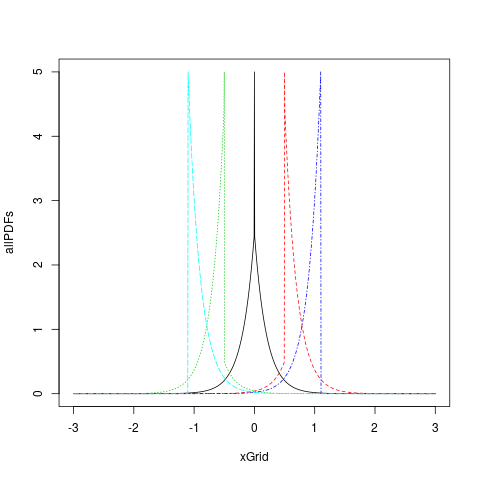

In [5]:
%%R 

xGrid <- seq(-3, 3, 0.005)

pdfs <- c(dtransition(xGrid, 0))
pdfs <- c(pdfs, dtransition(xGrid, 0.5))
pdfs <- c(pdfs, dtransition(xGrid, -0.5))
pdfs <- c(pdfs, dtransition(xGrid, 1.1))
pdfs <- c(pdfs, dtransition(xGrid, -1.1))

allPDFs <- matrix(pdfs, ncol=5)
matplot(xGrid, allPDFs, type="l")

## And vectorise the transition simulation

In [5]:
%%R

lambda <- 5

rtransition <- function(x) { 

    E <- rexp(1, lambda)
    
    probJumpLeft <- (1 / (x+1)^2) / 
        ((1 / (x+1)^2) + (1 / (x-1)^2))

    if (x > 1) {
        return( x - E )
    }
    if (x < -1) {
        return( x + E )
    }
    
    if (runif(1) < probJumpLeft) {
        return( x - rexp(1, lambda) )
    } else {
        return( x + rexp(1, lambda) )
    }
}

rtransition(0)

[1] 0.5320334


In [6]:
%%R

rtransitionVectorised <- function(x) { 
    
    R <- length(x)
    
    Es <- rexp(R, lambda)
    
    probJumpLeft <- (1 / (x+1)^2) / 
        ((1 / (x+1)^2) + (1 / (x-1)^2))
    
    jumpLeft <- (runif(R) < probJumpLeft)
    jumpLeft[which(x < -1)] <- FALSE
    jumpLeft[which(x > 1)] <- TRUE
    
    jumpSizes <- (-1)^jumpLeft * Es
    
    return(x + jumpSizes)
}

rtransitionVectorised(c(-1.5, 0, 1.5))

[1] -1.3049987  0.1950013  1.6950013


## Simulate the chain

In [95]:
%%R 
R <- 1000; N <- 5000

X <- matrix(rep(NA, N*R), nrow=N, ncol=R)

X[1,] <- rtransitionVectorised(rep(0, R))
for (n in 2:N)
    X[n,] <- rtransitionVectorised(X[n-1,])

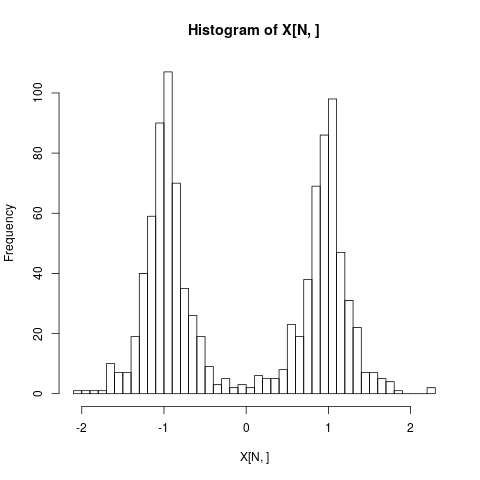

In [96]:
%%R 
# What's the distribution of X_N?
hist(X[N,], 40)
# library(ks)# plot(kde(X[N,]))

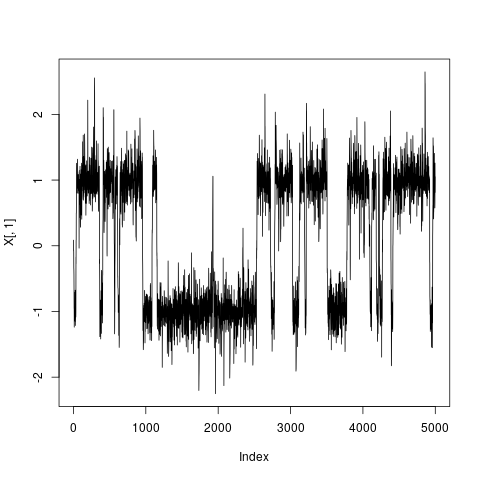

In [97]:
%%R 
# What does one sample path look like?
plot(X[,1], type="l")

## Compare histogram of $X_N$ to that of all $X_i$'s 

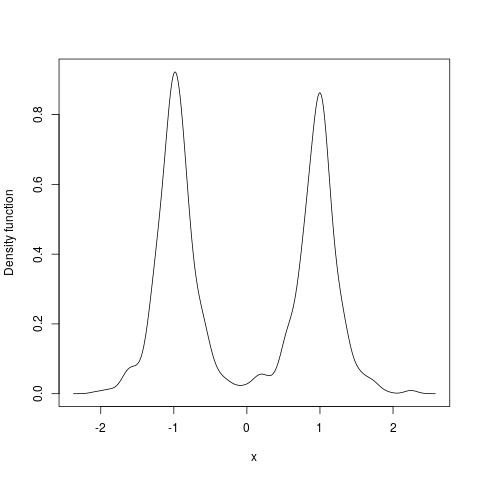

In [98]:
%%R
library(ks); plot(kde(X[N,]))

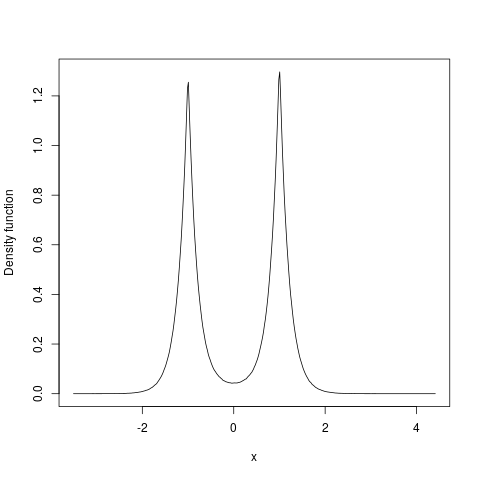

In [99]:
%%R
library(ks); plot(kde(as.vector(X)))

## How does this compare with a different starting position?

In [10]:
%%R 
R <- 1000; N <- 500
X <- matrix(rep(NA, R*N), nrow=N, ncol=R)

X[1,] <- rtransitionVectorised(rep(100, R))

for (n in 2:N)
    X[n,] <- rtransitionVectorised(X[n-1,])

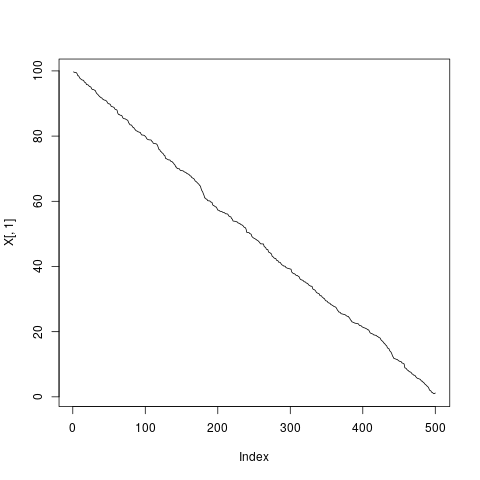

In [11]:
%%R
# Plot one sample path
plot(X[,1], type="l")

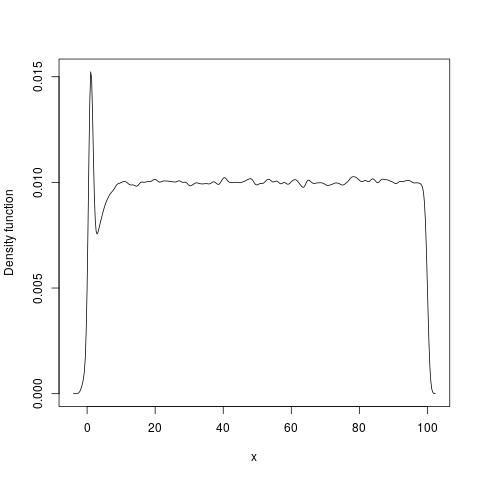

In [13]:
%%R
# Plot histograms for X_N and all X_i's
#plot(kde(X[N,]))
library(ks); plot(kde(as.vector(X)))
#plot(kde(as.vector(X[1000:N,])))

## Markov chain Monte Carlo



_Input_: $f_X$, $R$, $q$, $X_0$

To generate the $r$-th random variable:   
$\quad$ Make a proposal $Y$ from the distribution $q(\,\cdot\, \mid X_{r-1})$  
$\quad$ With probability $\alpha(X_{r-1}, Y)$:  
$\quad$ $\quad$ We accept the proposal, so $X_r \gets Y$  
$\quad$ Otherwise:  
$\quad$ $\quad$ We reject and stay where we are, so $X_r \gets X_{r-1}$  
Return $(X_1, \dots, X_R)$

Here we use
$$\alpha(X,Y) := \min\Bigl\{ \frac{ f_X(Y) \, q(X_{r-1} \mid Y)
}{ f_X(X_{r-1}) \, q(Y \mid X_{r-1}) } , 1 \Bigr\} $$


_Input_: $f_X$, $R$, $q$, $X_0$

For $r = 1$ to $R$  
$\quad$ $Y \sim q(\,\cdot\, \mid X_{r-1})$  
$\quad$ $U \sim \mathsf{Unif}(0,1)$  
$\quad$ If 
$U \le \alpha(X_{r-1}, Y) = \min\bigl\{  \frac{ f_X(Y) \, q(X_{r-1} \mid Y) 
}{ f_X(X_{r-1}) \, q(Y \mid X_{r-1}) } , 1 \bigr\} $  
$\quad$ $\quad$ $X_r \gets Y$  
$\quad$ Else  
$\quad$ $\quad$ $X_r \gets X_{r-1}$  
$\quad$ End If  
End For  
Return $(X_1, \dots, X_R)$

## Example: sampling from $Z \mid Z > 5$ 

Will propose jumps which are Laplace distributed (i.e. double exponential distributed)

$$ X \sim \mathsf{Laplace}(\mu, \lambda) \quad \Rightarrow \quad f_X(x) = \frac{1}{2\lambda} \exp \,\Bigl\{ \frac{| x - \mu | }{\lambda} \Bigr\} $$

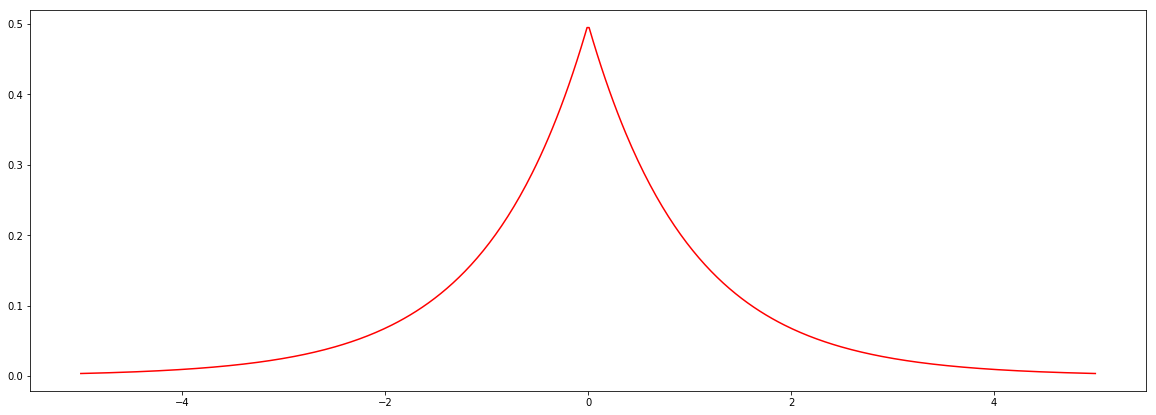

In [106]:
xs = np.linspace(-5,5, 500)
plt.plot(xs, stats.laplace.pdf(xs), 'r');

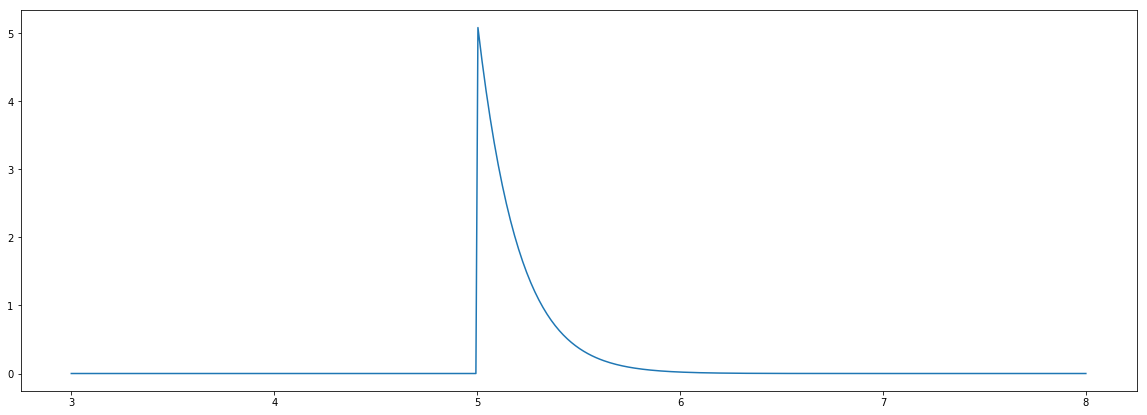

In [108]:
zs = np.linspace(3, 8, 500)
plt.plot(zs, (zs > 5) * stats.norm.pdf(zs) / (stats.norm.sf(5)));

_Input_:
$$f_X(x) \propto 1\{x > 5\} f_Z(x) , \quad R = 10^6, \quad X_0 = 5.01, \quad
q(x_r \mid x_{r-1}) = \frac{1}{2\lambda} \exp \,\Bigl\{ -\frac{| x_r - x_{r-1} | }{\lambda} \Bigr\}$$
Note: $q(x_r \mid x_{r-1}) = q(x_{r-1} \mid x_r)$

For $r = 1$ to $R$  
$\quad$ $Y \sim \mathsf{Laplace}(X_{r-1}, \lambda)$   
$\quad$ $U \sim \mathsf{Unif}(0,1)$  
$\quad$ If 
$U \le \frac{ f_X(Y) q(X_{r-1} \mid Y)
}{ f_X(X_{r-1}) q(Y \mid X_{r-1}) } = \frac{ f_X(Y) }{ f_X(X_{r-1}) } = 1\{Y > 5\} \mathrm{e}^{ \frac12 (X_{r-1}^2 - Y^2) } $  
$\quad$ $\quad$ $X_r \gets Y$  
$\quad$ Else  
$\quad$ $\quad$ $X_r \gets X_{r-1}$  
$\quad$ End If  
End For  
Return $(X_1, \dots, X_R)$


To generate the $r$-th random variable:   
$\quad$ Make a proposal $Y$ from the distribution $\mathsf{Laplace}(X_{r-1}, \lambda)$  
$\quad$ Three scenarios:  
$\quad$ $\quad$ a) $Y$ is not valid ($f_X(Y) = 0$, e.g. $Y \le 5$)  
$\quad$ $\quad$ $\quad$ We reject and stay where we are, so $X_r \gets X_{r-1}$  
$\quad$ $\quad$ b) $Y$ is valid are more likely than $X_{r-1}$ ($\frac{ f_X(Y) }{ f_X(X_{r-1}) } \ge 1$)  
$\quad$ $\quad$ $\quad$ We accept the proposal, so $X_r \gets Y$  
$\quad$ $\quad$ c) $Y$ is valid but less likely than $X_{r-1}$ ($\frac{ f_X(Y) }{ f_X(X_{r-1}) } < 1$)  
$\quad$ $\quad$ $\quad$ We accept with probability $\frac{ f_X(Y) }{ f_X(X_{r-1}) }$, and reject otherwise.  


## Into R land

For $r = 1$ to $R$  
$\quad$ $Y \sim \mathsf{Laplace}(X_{r-1}, \lambda)$   
$\quad$ $U \sim \mathsf{Unif}(0,1)$  
$\quad$ If 
$U \le \frac{ f_X(Y) q(X_{r-1} \mid Y)
}{ f_X(X_{r-1}) q(Y \mid X_{r-1}) } = \frac{ f_X(Y) }{ f_X(X_{r-1}) } = 1\{Y > 5\} \mathrm{e}^{ \frac12 (X_{r-1}^2 - Y^2) } $  
$\quad$ $\quad$ $X_r \gets Y$  
$\quad$ Else  
$\quad$ $\quad$ $X_r \gets X_{r-1}$  
$\quad$ End If  
End For  
Return $(X_1, \dots, X_R)$


In [151]:
%%R 

lambda <- 10
Xstart <- 5.01
R <- 5 * 10^6
Xs <- rep(NA, R)

Xs[1] <- Xstart

for (r in 2:R) {
    # Generate proposal
    U1 <- (runif(1) < 0.5)
    sign <- (-1)^U1
    Y <- Xs[r-1] + sign * rexp(1, lambda)
    
    # Calculate acceptance probability.
    alpha <- (Y > 5) * exp(0.5 * (Xs[r-1]^2 - Y^2))
    # Transition with this probability
    U <- runif(1)
    if (U < alpha) {
        Xs[r] <- Y
    } else {
        Xs[r] <- Xs[r-1]
    }
}

## The histogram of the samples against the desired density

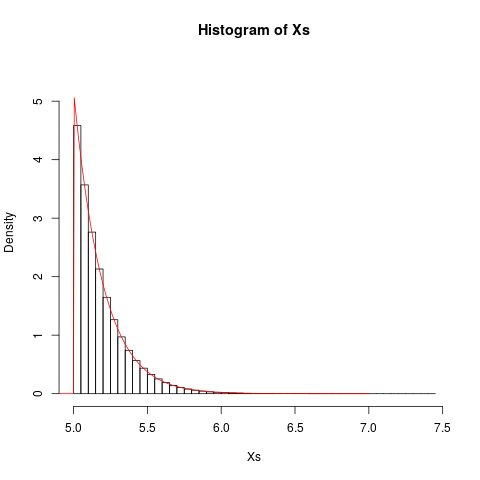

In [168]:
%%R
hist(Xs, 40, prob=T, ylim=c(0, 5.5))
zs <- seq(4.9, 7, 0.005)
lines(zs, (zs > 5) * dnorm(zs) / (1-pnorm(5)), col="red");